In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_inter = pd.read_csv('./data/interactions.csv', parse_dates=['last_watch_dt'], dayfirst=True)
df_items = pd.read_csv('./data/items.csv')
df_users = pd.read_csv('./data/users.csv')

In [4]:
users_in_df_users = set(df_users['user_id'].values)
users_in_df_inter = set(df_inter['user_id'].values)
users_to_stay = users_in_df_users.intersection(users_in_df_inter)

df_users_mask = df_users['user_id'].apply(lambda user: user in users_to_stay)
df_inter_mask = df_inter['user_id'].apply(lambda user: user in users_to_stay)

df_users = df_users[df_users_mask].reset_index(drop=True)
df_inter = df_inter[df_inter_mask].reset_index(drop=True)


items_in_df_items = set(df_items['item_id'].values)
items_in_df_inter = set(df_inter['item_id'].values)
items_to_stay = items_in_df_items.intersection(items_in_df_inter)

df_items_mask = df_items['item_id'].apply(lambda item: item in items_to_stay)
df_inter_mask = df_inter['item_id'].apply(lambda item: item in items_to_stay)

df_items = df_items[df_items_mask].reset_index(drop=True)
df_inter = df_inter[df_inter_mask].reset_index(drop=True)

In [5]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15008 entries, 0 to 15007
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15008 non-null  int64  
 1   content_type  15008 non-null  object 
 2   title         15008 non-null  object 
 3   title_orig    10749 non-null  object 
 4   release_year  14922 non-null  float64
 5   genres        15008 non-null  object 
 6   countries     14974 non-null  object 
 7   for_kids      558 non-null    float64
 8   age_rating    15007 non-null  float64
 9   studios       994 non-null    object 
 10  directors     13660 non-null  object 
 11  actors        12581 non-null  object 
 12  description   15007 non-null  object 
 13  keywords      14593 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.6+ MB


In [6]:
df_inter.sample(2)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1275681,679182,12192,2021-07-22,8047,10.0
605977,150728,931,2021-05-17,10238,100.0


In [7]:
df_items.sample(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
6367,354,film,Серая сова,Grey Owl,1998.0,"драмы, биография, вестерн","Великобритания, Канада",NaN,12.0,NaN,Ричард Аттенборо,"Пирс Броснан, Стюарт Бик, Власта Врана, Анни Г...",Британец Арчи Белани считал своим домом дикие ...,"1998, соединенное королевство, канада, серая, ..."
3359,2880,film,Необитаемый остров,Uninhabited,2010.0,"зарубежные, триллеры, ужасы",Австралия,NaN,16.0,NaN,Билл Беннетт,"Билли Милионис, Боб Бэйнс, Генри Джеймс, Джера...",На маленьком австралийском острове находит при...,"Необитаемый, остров, 2010, Австралия"


In [8]:
df_users.sample(2)

,user_id,age,income,sex,kids_flg
352612,1093599,age_35_44,income_20_40,М,1
51499,754241,age_45_54,income_20_40,М,0


## Interactions

### Overview

The most popular movies

In [9]:
views = df_inter.groupby('item_id').size().rename('views')
df_items = df_items.merge(views, left_on='item_id', right_index=True).\
    sort_values('views', ignore_index=True, ascending=False)

df_items[:10][['title', 'views', 'release_year', 'actors', 'description']]

,title,views,release_year,actors,description
0,Хрустальный,133553,2021.0,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...
1,Клиника счастья,127620,2021.0,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор..."
2,Гнев человеческий,112894,2021.0,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...
3,Девятаев,97995,2021.0,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...
4,Секреты семейной жизни,66206,2021.0,"Петр Скворцов, Алена Михайлова, Федор Лавров, ...",У Никиты и Полины всё начиналось прекрасно: об...
5,Прабабушка легкого поведения,60214,2021.0,"Александр Ревва, Глюкоза, Дмитрий Нагиев, Миха...","1980 год, вся страна следит за событиями моско..."
6,Афера,43337,2021.0,"Сергей Степин, Игорь Царегородцев, Татьяна Лял...","Смотри:- как кино- как сериалКарантин окончен,..."
7,Подслушано,41307,2021.0,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...
8,Маша,34501,2020.0,"Максим Суханов, Аня Чиповская, Полина Гухман, ...",13-летняя Маша растёт между боксёрским рингом ...
9,Белый снег,29773,2021.0,"Ольга Лерман, Федор Добронравов, Надежда Марки...",Отечественная спортивная драма про лыжницу и о...


cumplots of views

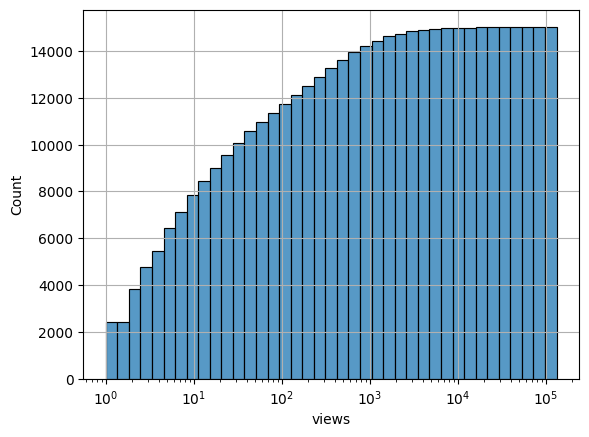

In [10]:
df_views = df_items['views']
sns.histplot(df_views, log_scale=True, cumulative=True)
plt.grid()

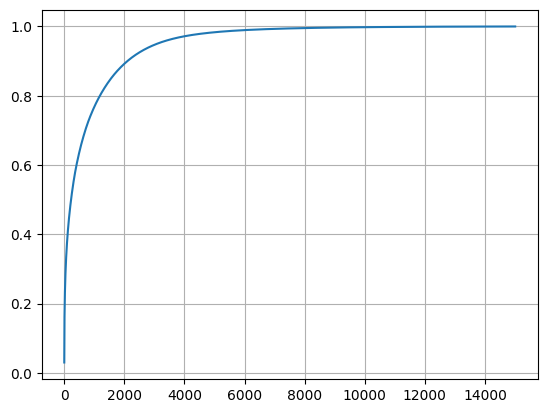

In [11]:
cumsum = df_views.cumsum()
cumsum = cumsum / cumsum.iloc[-1]
cumsum.index = np.arange(1, len(df_views)+1)
cumsum.plot()
plt.grid()

In [37]:
cumsum[1999], df_views[1999]

(0.8922602603652364, 352)

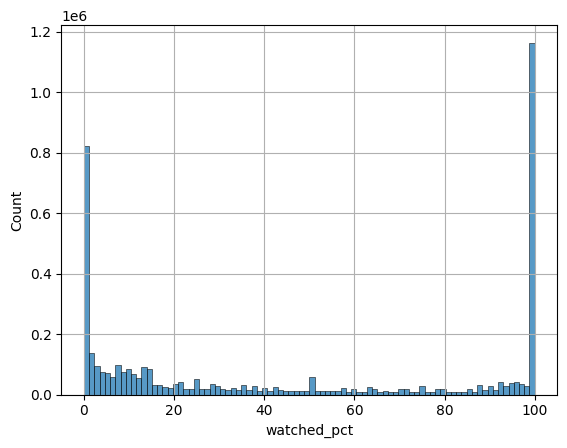

In [13]:
sns.histplot(data=df_inter, x='watched_pct')
plt.grid()

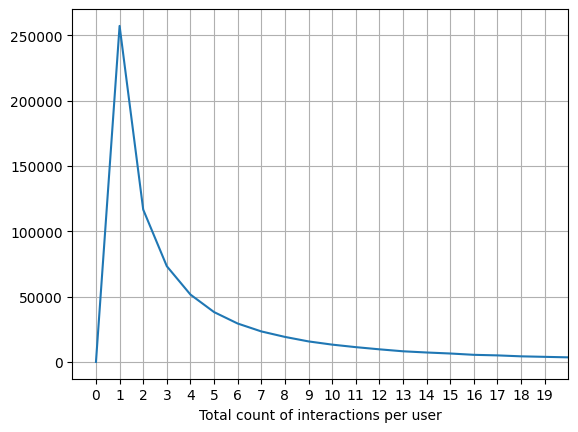

In [14]:
a = df_inter.groupby('user_id').size().value_counts()
a[0] = 0
a.sort_index().plot()
plt.xlabel('Total count of interactions per user')
plt.xlim([-1, 20])
plt.xticks(range(20))
plt.grid()

### Preparation

In [15]:
df_inter.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      661
dtype: int64

In [16]:
df_inter.drop(['total_dur'], axis=1, inplace=True)
df_inter['watched_pct'] = df_inter['watched_pct'].fillna(50.)

df_inter.sort_values('last_watch_dt', inplace=True)

In [17]:
df_inter.sample(1)

,user_id,item_id,last_watch_dt,watched_pct
1157095,883957,3784,2021-07-27,98.0


Save modified data to new csv-file.

In [18]:
df_inter.to_csv('./processed_data/interactions.csv', index=False)

## Items

### Overview

In [19]:
df_items.describe(include='object')

,content_type,title,title_orig,genres,countries,studios,directors,actors,description,keywords
count,15008,15008,10749,15008,14974,994,13660,12581,15007,14593
unique,2,14401,10149,2669,672,38,7647,12258,14689,14547
top,film,Охота,Pet Sematary,документальное,США,HBO,Оливье Шиабоду,Александр Клюквин,МТС «Карантинники» — это домашние акустические...,"2015, чехия, компания, трех"
freq,11371,5,4,771,3919,328,489,25,36,6


In [20]:
df_items['content_type'].value_counts()

content_type
film      11371
series     3637
Name: count, dtype: int64

In [21]:
df_items['age_rating'].value_counts().sort_index()

age_rating
0.0     1405
6.0     1430
12.0    3844
16.0    5389
18.0    2459
21.0     480
Name: count, dtype: int64

In [22]:
df_items['genres'].value_counts()

genres
документальное                                                                            771
драмы                                                                                     690
комедии                                                                                   549
для взрослых                                                                              480
русские, мелодрамы                                                                        347
                                                                                         ... 
биография, криминал, драмы, зарубежные, комедии                                             1
драмы, русские, криминал, военные                                                           1
драмы, фантастика, детективы, мелодрамы                                                     1
сказки, полнометражные, приключения, зарубежные, мелодрамы, семейное, фэнтези, комедии      1
советские, фильмы, семейное, приключения             

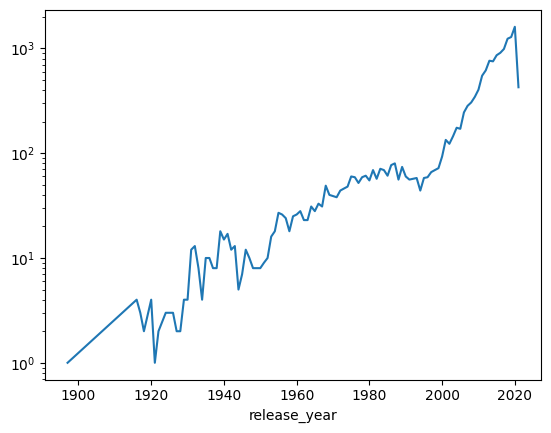

In [23]:
df_items['release_year'].value_counts().sort_index().plot(logy=True);

In [24]:
listoflists = df_items['keywords'].apply(lambda line: str(line).split(', '))
keywords = [word for line in listoflists for word in line]
pd.Series(keywords).value_counts().head(10)

отношения            8184
Россия               2968
соединенные штаты    2777
женщины              2401
любовь               2332
мужчины              2000
США                  1973
преодоление          1887
трудностей           1885
борьба               1783
Name: count, dtype: int64

In [25]:
df_items.sample(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,views
8815,524,film,Вельзевул (жестовым языком),Belzebuth (Sign Language),2019.0,"ужасы, зарубежные",Мексика,NaN,18.0,NaN,Эмилио Портес,"Тобин Белл, Хоакин Косио, Тейт Эллингтон, Норм...",Детектив Риттер в свое время потерял при траги...,"Вельзевул, жестовым, языком, 2019, Мексика",6


### Preparation

In [26]:
df_items_mod = df_items.drop(
    ['title_orig', 'release_year', 'countries', 'for_kids', 'studios',
     'directors', 'actors', 'description'], axis=1)

In [27]:
df_items_mod.isnull().sum()

item_id           0
content_type      0
title             0
genres            0
age_rating        1
keywords        415
views             0
dtype: int64

In [28]:
df_items_mod['age_rating'] = df_items_mod['age_rating'].fillna(0)
df_items_mod['age_rating'] = df_items_mod['age_rating'].astype(int)
df_items_mod['age_rating'] = df_items_mod['age_rating'].astype('object')

In [29]:
df_items_mod.sample(1)

,item_id,content_type,title,genres,age_rating,keywords,views
2106,6588,film,Сказки Серого Волка,"мультфильм, комедии",6,", Сериал мини-формата, 2016, соединенное корол...",323


In [30]:
df_items_mod.to_csv('./processed_data/items.csv', index=False)

## Users overview

### Overview

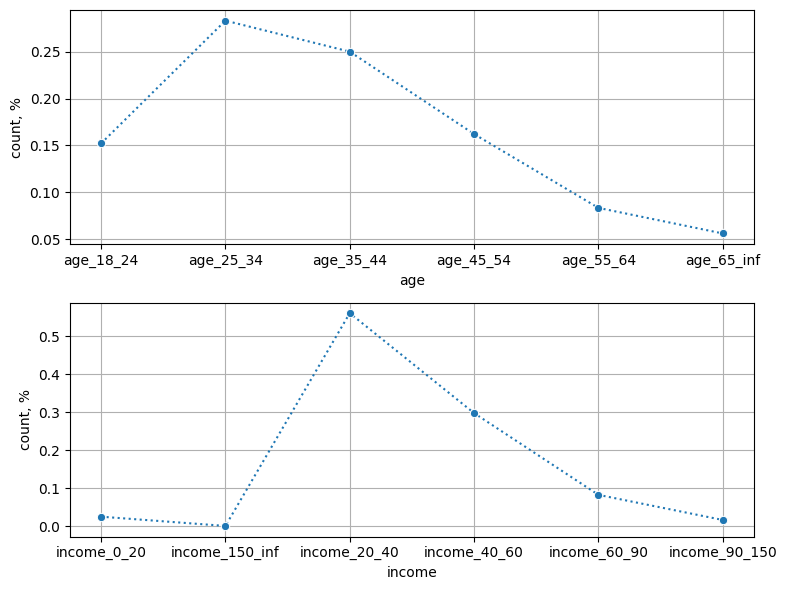

In [31]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
sns.lineplot(df_users['age'].value_counts().sort_index()/len(df_users), linestyle='dotted', marker='o')
plt.ylabel('count, %')
plt.grid()

plt.subplot(2, 1, 2)
sns.lineplot(df_users['income'].value_counts().sort_index()/len(df_users), linestyle='dotted', marker='o')
plt.ylabel('count, %')
plt.grid()

plt.tight_layout()

In [32]:
df_users.describe(include='object')

,age,income,sex
count,734570,734694,734772
unique,6,6,2
top,age_25_34,income_20_40,Ж
freq,210637,417900,378095


In [33]:
df_users['kids_flg'].value_counts()

kids_flg
0    516988
1    227300
Name: count, dtype: int64

### Preparation

In [34]:
df_users['kids_flg'] = df_users['kids_flg'].fillna(0)
df_users['age'] = df_users['age'].fillna('age_25_34')
df_users['income'] = df_users['income'].fillna('income_20_40')
df_users['sex'] = df_users['sex'].fillna('Ж')

In [35]:
df_users.to_csv('./processed_data/users.csv', index=False)